In [6]:
import sys; sys.path.insert(0, '..')
from database.dataset import *
import pyforest
import matplotlib.pyplot as plt
plt.style.use('default')
import cv2
from math import sqrt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from skimage.feature import blob_dog, hessian_matrix

In [7]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        extract_patches=False,
        normalize=None,
        n_jobs=-1,
)


In [8]:
list_img = [db[i]['img'] for i in range(10)]

#### Plot functions

In [19]:
def plot_img_rois(index: int, colors = ['yellow','orange'], linewidth = 1,radius = 6):
    """
    Plots the original image with rois as markers. Rectangles for rois with bounding boxes
    and circles with given radius for point lesions. Both markers with given linewidth and colors.

    Args:
        index (int): index of item in the database instance INBreast_Dataset
        colors (list, optional): color of the marker [rectangles, circles]. Defaults to ['yellow','orange'].
        linewidth (int, optional): width of line. Defaults to 1.
        radius (int, optional): radius of circles. Defaults to 6.
    """
    f,ax = plt.subplots(1,2,figsize=(10,8))
    ax[0].imshow(db[index]['img'],cmap='gray') # display image
    
    lesion_bbxs = [[bbox[0],bbox[1][0]-bbox[0][0],bbox[1][1]-bbox[0][1]] \
         for bbox in db[index]['lesion_bboxes'] if bbox[0] != bbox[1]] # get lesion boxes

    lesion_pts = [bbox[0] for bbox in db[index]['lesion_bboxes'] if bbox[0] == bbox[1]] # get lesion points
    
    for coords,width,height in lesion_bbxs:
        rec = plt.Rectangle(coords, width=width, height=height, color=colors[0], linewidth=linewidth, fill=False)
        ax[0].add_patch(rec)
    for coords in lesion_pts:
        c = plt.Circle(coords, radius=radius, color=colors[1], linewidth=linewidth, fill=False)
        ax[0].add_patch(c)
    ax[0].set_title('Image with ROIs')
    ax[0].axis('off')
    ax[1].imshow(db[index]['lesion_mask'])
    ax[1].set_title('Image mask')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [18]:
def easy_plot(i: int):
    """Plots the original image and mask, of instance INBreast_Dataset

    Args:
        i (int): index of item
    """
    f,ax = plt.subplots(1,2,figsize=(8,6))
    ax[0].imshow(db[i]['img'], cmap='gray' )
    ax[1].imshow(db[i]['lesion_mask'])
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [17]:
def gaus_plot(i,img_gaus):
    f,ax = plt.subplots(1,2,figsize=(8,6))
    ax[0].imshow(db[i]['img'], cmap='gray' )
    ax[1].imshow(img_gaus,cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [15]:
import seaborn as sns

def plot_img_hist(img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(img,cmap='gray')
    sns.histplot(img.flatten(), ax=ax[1], bins=1000, element='poly', alpha=0.2)
    ax[1].set_yscale("log")

In [16]:
def plot_blobs(image,image_blobs):
    f,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(image,cmap='gray')
    for blob in tqdm(image_blobs):
        y,x,r = blob
        c = plt.Circle((x, y), r, color='yellow', linewidth=1, fill=False)
        ax.add_patch(c)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Pipe 1

In [21]:
def circle_comparison(true_bboxes, predicted_roi_circles, mask):
    """Finds TP, FP and number of FN for a prediction of circles given image mask

    Args:
        true_bboxes (np.ndarray): Array of shape (n_rois, 2) containing
            tl and br bbox coordinates in tuples
        predicted_roi_circles (np.ndarray): Array of shape (n_predicted_circ, 3)
            with circle_x, circle_y and circle_radius values
        mask (np.ndarray): Image mask containing indexes of rois

    Returns:
        TP (set): contains TP roi indexes
        FP (set): contains FP circle indexes (that weren't mapped to any rois)
        FN (int): number of rois not mapped to any of the predicted circles
    """
    TP = set()
    FP = []

    true_mask = mask

    for circle_idx, circle in enumerate(predicted_roi_circles.astype(int)):
        circle_roi_mask=cv2.circle(np.zeros(mask.shape),
                                     (circle[0], circle[1]),
                                     circle[2], 1, -1).astype(np.bool8)

        mapped_rois_idxs=set(
            np.unique(true_mask[circle_roi_mask])).difference(set([0]))
        if len(mapped_rois_idxs) > 0:
            TP = TP.union(mapped_rois_idxs)
        else:
            FP.append(circle_idx)
    FN = len(true_bboxes) - len(TP)
    return TP, FP, FN

In [9]:
def norm_image(image):
    return (image-image.min())/(image.max()-image.min()) # image normalization

In [12]:
def get_image_blobs(image: np.ndarray):
    """Process image to get candidate blobs of microcalcifications with HDoG altorithm from
    MARASINOU et al. (2021):SEGMENTATION OF BREAST MICROCALCIFICATIONS: A MULTI-SCALE APPROACH

    Args:
        image (np.ndarray): mammogram image

    Returns:
        img_binary_blobs (np.ndarray): binary image of candidate blobs
        blobs_filtered (list): list of blobs coordinates and associated sigma [r(int),c(int),sigma(float)]
    """
    # set parameters
    sigma_ratio = 1.05
    n_scales = 20
    max_sigma = 3.1
    min_sigma = 1.18
    t_dog = 0.006
    overlap_dog = 1
    h_thr = 1.4

    # normalize image
    image = norm_image(image) 

    # set sigmas of scale-space
    sigma_array = np.array([min_sigma*(sigma_ratio**n) for n in range(n_scales+1)]) 

    # get gaussian-blurr images
    gaussian_images = [gaussian_filter(image, s, mode='reflect') for s in sigma_array] 

    # get normalized difference of gaussians
    sf = 1/(sigma_ratio-1)
    img_dog = [sf*(gaussian_images[i] - gaussian_images[i+1]) for i in range(n_scales)] 
    img_dog = np.asarray(img_dog)

    # compute hessian of dog scale-space and get binary mask from condition
    img_hdog_filter = []
    for sigma_idx,dog in enumerate(tqdm(img_dog)):
        hrr,hrc,hcc = hessian_matrix(dog,sigma=sigma_array[sigma_idx],mode='constant') #
        trace = hrr + hcc
        det = (hrr*hcc) - hrc**2 #hessian_matrix_det(dog)
        hessian_mask = ((trace < 0) & ((det < 0) | (np.abs(det)/(trace**2) <= h_thr)))
        img_hdog_filter.append(hessian_mask)
    
    img_hdog_filter = np.asarray(img_hdog_filter)

    # extract blobs from dog scale-space maxima
    img_blobs = blob_dog(image,min_sigma=min_sigma,max_sigma=max_sigma,sigma_ratio=sigma_ratio,threshold=t_dog,overlap=overlap_dog)
    
    # Select blobs 
    blobs_filtered = []
    blob_coords = img_blobs[:,:2].astype(int)

    for blob_index,blob_sigma in enumerate(tqdm(img_blobs[:,2])):
        hess_mask = img_hdog_filter[np.where(sigma_array == blob_sigma)][0]
        if hess_mask[blob_coords[blob_index][0],blob_coords[blob_index][1]]:
            blobs_filtered.append([blob_coords[blob_index][0],blob_coords[blob_index][1],blob_sigma]) 

    print(f'No. of blobs: {img_blobs.shape[0]}')
    print(f'No. of blobs after hessian condition: {np.shape(blobs_filtered)[0]}')


    # create binary mask
    img_binary_blobs = np.zeros(image.shape)

    for blob in blobs_filtered:
        img_binary_blobs = cv2.circle(img_binary_blobs,(blob[1],blob[0]),int(blob[2]*sqrt(2)),255,-1)
    
    return img_binary_blobs, blobs_filtered


In [13]:
%%time
img_idx = 0
img_mask,blob_list = get_image_blobs(list_img[img_idx])

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1422/454507921.py:41: RuntimeWarning: divide by zero encountered in true_divide
  hessian_mask = ((trace < 0) & ((det < 0) | (np.abs(det)/(trace**2) <= h_thr)))
/tmp/ipykernel_1422/454507921.py:41: RuntimeWarning: invalid value encountered in true_divide
  hessian_mask = ((trace < 0) & ((det < 0) | (np.abs(det)/(trace**2) <= h_thr)))
100%|██████████| 135832/135832 [01:53<00:00, 1196.81it/s]


No. of blobs: 135832
No. of blobs after hessian condition: 135793
CPU times: user 6min 18s, sys: 31.5 s, total: 6min 49s
Wall time: 6min 54s


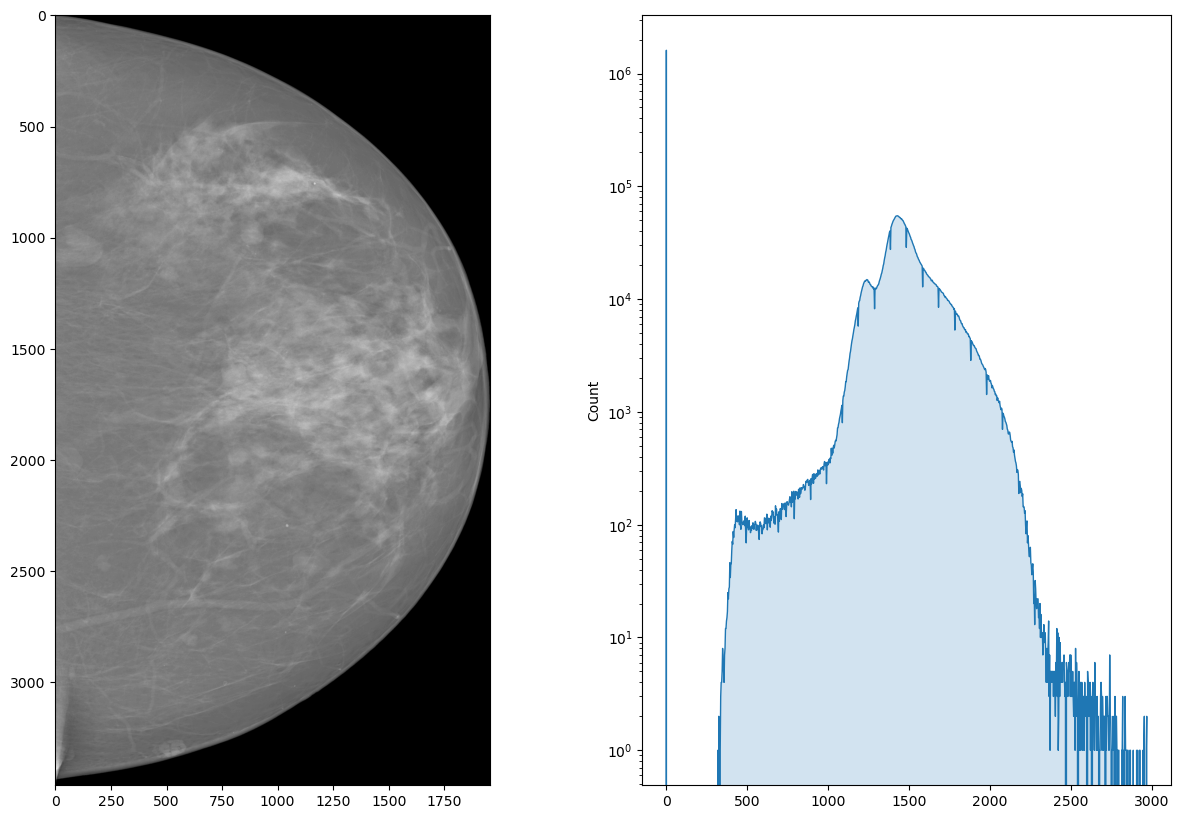

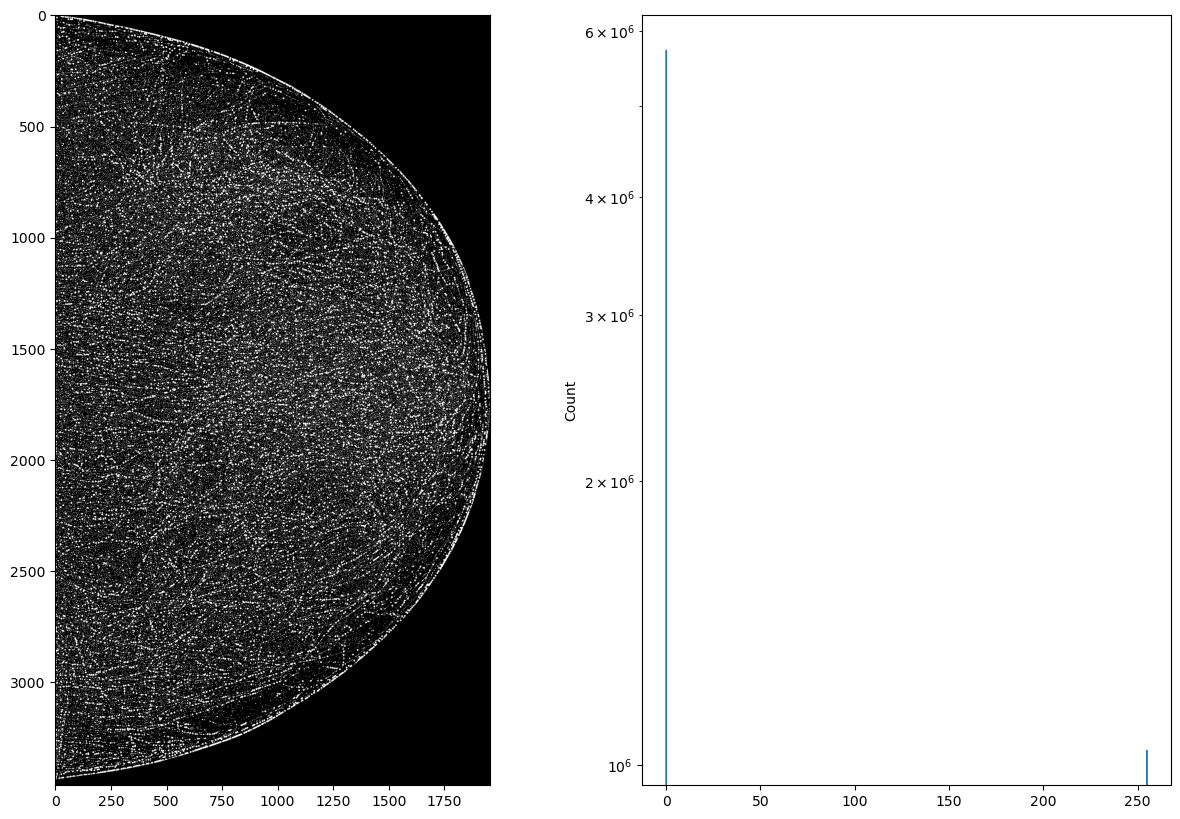

In [20]:
plot_img_hist(list_img[0])
plot_img_hist(img_mask)

In [22]:
type(blob_list)

list

In [32]:
blob_list_arr = np.array(blob_list.copy())
blob_list_arr[:,2] = blob_list_arr[:,2]*sqrt(2)
blob_list_arr[:,[0, 1]] = blob_list_arr[:,[1, 0]]

TP, FP, FN = circle_comparison(db[img_idx]['lesion_bboxes'],blob_list_arr,)

In [39]:
db[0].keys()


dict_keys(['idx', 'lab', 'img', 'lesion_bboxes', 'lesion_mask', 'side'])